# Homework 4: Conversation Modeling and decoding

In [ ]:
import re
from collections import Counter
from tqdm import tqdm
import json
from torch.utils.data import Dataset, DataLoader
import torch
import random

# Part 1 Modeling

## 1.1 Attention visulization

In [ ]:
RETOK = re.compile(r'\w+|[^\w\s]|\n', re.UNICODE)

In [ ]:
class ChatDictionary(object):
    """
    Simple dict loader
    """
    def __init__(self, dict_file_path):
        self.word2ind = {}  # word:index
        self.ind2word = {}  # index:word
        self.counts = {}  # word:count

        dict_raw = open(dict_file_path, 'r').readlines()
        
        for i, w in enumerate(dict_raw):
            _word, _count = w.strip().split('\t')
            if _word == '\\n':
                _word = '\n'
            self.word2ind[_word] = i
            self.ind2word[i] = _word
            self.counts[_word] = _count
            
    def t2v(self, tokenized_text):
        return [self.word2ind[w] if w in self.counts else self.word2ind['__unk__'] for w in tokenized_text]

    def v2t(self, list_ids):
        return ' '.join([self.ind2word[i] for i in list_ids])
    
    def pred2text(self, tensor):
        result = []
        for i in range(tensor.size(0)):
            if tensor[i].item() == '__end__'  or tensor[i].item() == '__null__':  # null is pad
                break
            else:
                result.append(self.ind2word[tensor[i].item()])
        return ' '.join(result)
    
    def __len__(self):
        return len(self.counts)

In [ ]:
class ChatDataset(Dataset):
    """
    Json dataset wrapper
    """
    
    def __init__(self, dataset_file_path, dictionary, dt='train'):
        super().__init__()
        
        json_text = open(dataset_file_path, 'r').readlines()
        self.samples = []
        
        for sample in tqdm(json_text):
            sample = sample.rstrip()
            sample = json.loads(sample)
            _inp_toked = RETOK.findall(sample['text'])
            _inp_toked_id = dictionary.t2v(_inp_toked)

            sample['text_vec'] = torch.tensor(_inp_toked_id, dtype=torch.long)
            
            # train and valid have different key names for target
            if dt == 'train':
                _tar_toked = RETOK.findall(sample['labels'][0]) + ['__end__']
            elif dt == 'valid':
                _tar_toked = RETOK.findall(sample['eval_labels'][0]) + ['__end__']
                
            _tar_toked_id = dictionary.t2v(_tar_toked)
            
            sample['target_vec'] = torch.tensor(_tar_toked_id, dtype=torch.long)
            
            self.samples.append(sample)
            
    def __getitem__(self, i):
        return self.samples[i]['text_vec'], self.samples[i]['target_vec']
    
    def __len__(self):
        return len(self.samples)

In [ ]:
def pad_tensor(tensors, sort=True, pad_token=0):
    rows = len(tensors)
    lengths = [len(i) for i in tensors]
    max_t = max(lengths)
        
    output = tensors[0].new(rows, max_t)
    output.fill_(pad_token)  # 0 is a pad token here
    
    for i, (tensor, length) in enumerate(zip(tensors, lengths)):
        output[i,:length] = tensor

    return output, lengths

def argsort(keys, *lists, descending=False):
    """Reorder each list in lists by the (descending) sorted order of keys.
    :param iter keys: Keys to order by.
    :param list[list] lists: Lists to reordered by keys's order.
                             Correctly handles lists and 1-D tensors.
    :param bool descending: Use descending order if true.
    :returns: The reordered items.
    """
    ind_sorted = sorted(range(len(keys)), key=lambda k: keys[k])
    if descending:
        ind_sorted = list(reversed(ind_sorted))
    output = []
    for lst in lists:
        if isinstance(lst, torch.Tensor):
            output.append(lst[ind_sorted])
        else:
            output.append([lst[i] for i in ind_sorted])
    return output

def batchify(batch):
    inputs = [i[0] for i in batch]
    labels = [i[1] for i in batch]
    
    input_vecs, input_lens = pad_tensor(inputs)
    label_vecs, label_lens = pad_tensor(labels)
    
    # sort only wrt inputs here for encoder packinng
    input_vecs, input_lens, label_vecs, label_lens = argsort(input_lens, input_vecs, input_lens, label_vecs, label_lens, descending=True)

    return {
        "text_vecs": input_vecs,
        "text_lens": input_lens,
        "target_vecs": label_vecs,
        "target_lens": label_lens,
        'use_packed': True
    }

In [110]:
# loading datasets and dictionary

# downloading pretrained models and data

### DOWNLOADING THE FILES
import os

### persona chat dataset
if not os.path.exists('./dict'):
    !wget "https://nyu.box.com/shared/static/sj9f87tofpicll89xbc154pmbztu5q4h" -O './dict'
if not os.path.exists('./train.jsonl'):
    !wget "https://nyu.box.com/shared/static/aqp0jyjaixjmukm5asasivq2bcfze075.jsonl" -O './train.jsonl'
if not os.path.exists('./valid.jsonl'):
    !wget "https://nyu.box.com/shared/static/eg4ivddtqib2hkf1k8rkxnmzmo0cq27p.jsonl" -O './valid.jsonl'

if not os.path.exists('./chat_model_best_22.pt'):
    !wget "https://nyu.box.com/shared/static/24zsynuks8nzg7530tgakzh8o62id9xa.pt" -O './chat_model_best_22.pt'

chat_dict = ChatDictionary('./dict')
train_dataset = ChatDataset('./train.jsonl', chat_dict)
valid_dataset = ChatDataset('./valid.jsonl', chat_dict, 'valid')

100%|██████████| 7801/7801 [00:00<00:00, 13588.76it/s]


In [ ]:
train_loader = DataLoader(train_dataset, shuffle=True, collate_fn=batchify, batch_size=256)
valid_loader = DataLoader(valid_dataset, shuffle=False, collate_fn=batchify, batch_size=256)

### Set up the model 

In [ ]:
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class EncoderRNN(nn.Module):
    """Encodes the input context."""

    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, pad_idx=0, dropout=0, shared_lt=None):
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = nn.Dropout(p=dropout)
        self.pad_idx = pad_idx
        
        if shared_lt is None:
            self.embedding = nn.Embedding(self.vocab_size, self.embed_size, pad_idx)
        else:
            self.embedding = shared_lt
            
        self.gru = nn.GRU(
            self.embed_size, self.hidden_size, num_layers=self.num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0,
        )
        
        
    def forward(self, text_vec, text_lens, hidden=None, use_packed=True):
        embedded = self.embedding(text_vec)
        attention_mask = text_vec.ne(self.pad_idx)

        embedded = self.dropout(embedded)
        if use_packed is True:
            embedded = pack_padded_sequence(embedded, text_lens, batch_first=True)
        output, hidden = self.gru(embedded, hidden)
        if use_packed is True:
            output, output_lens = pad_packed_sequence(output, batch_first=True)
        
        return output, hidden, attention_mask

    
class DecoderRNN(nn.Module):
    """Generates a sequence of tokens in response to context."""

    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, dropout=0):
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = nn.Dropout(p=dropout)
        
        self.embedding = nn.Embedding(self.vocab_size, self.embed_size, 0)
        
        self.gru = nn.GRU(
            self.embed_size, self.hidden_size, num_layers=self.num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0,
        )
        
        self.attention = AttentionLayer(self.hidden_size, self.embed_size)

        self.out = nn.Linear(self.hidden_size, self.vocab_size)
        self.longest_label = 100

    def forward(self, text_vec, decoder_hidden, encoder_states):
        emb = self.embedding(text_vec)
        emb = self.dropout(emb)
        seqlen = text_vec.size(1)
        encoder_output, encoder_hidden, attention_mask = encoder_states
        
        decoder_hidden = decoder_hidden
        output = []
        attn_w_log = []

        for i in range(seqlen):
            decoder_output, decoder_hidden = self.gru(emb[:,i,:].unsqueeze(1), decoder_hidden)
            
            # compute attention at each time step
            decoder_output_attended, attn_weights = self.attention(decoder_output, decoder_hidden, encoder_output, attention_mask)
            output.append(decoder_output_attended)
            attn_w_log.append(attn_weights)
            
        output = torch.cat(output, dim=1).to(text_vec.device)
        scores = self.out(output)
        
        return scores, decoder_hidden, attn_w_log
    
    def decode_forced(self, ys, encoder_states, xs_lens):
        encoder_output, encoder_hidden, attention_mask = encoder_states
        
        batch_size = ys.size(0)
        target_length = ys.size(1)
        longest_label = max(target_length, self.longest_label)
        
        starts = torch.Tensor([1]).long().to(self.embedding.weight.device).expand(batch_size, 1).long()  # expand to batch size
        
        # Teacher forcing: Feed the target as the next input
        y_in = ys.narrow(1, 0, ys.size(1) - 1)
        decoder_input = torch.cat([starts, y_in], 1)
        decoder_output, decoder_hidden, attn_w_log = self.forward(decoder_input, encoder_hidden, encoder_states)
        _, preds = decoder_output.max(dim=2)
        
        return decoder_output, preds, attn_w_log
    
    
class AttentionLayer(nn.Module):

    def __init__(self, hidden_size, embedding_size):
        super().__init__()
        input_dim = hidden_size

        # nn.Linear: applies a linear transformation to the incoming data 
        self.linear_out = nn.Linear(hidden_size+input_dim, input_dim, bias=False)
        self.softmax = nn.Softmax(dim=-1)
        self.tanh = nn.Tanh() # element-wise tanh 

    def forward(self, decoder_output, decoder_hidden, encoder_output, attention_mask):

        batch_size, seq_length, hidden_size = encoder_output.size()
        encoder_output_t = encoder_output.transpose(1,2) # batch_size x hidden_size x seq_len
        
        # torch.bmm: performs a batch matrix-matrix product of matrices stored in decoder_output(vector) and encoder_output_t(1x2 matrix) 
        #            input and mat2 must be 3-D tensors each containing the same number of matrices
        #            If input is a b×n×m tensor, mat2 is a b×m×p tensor, out will be a b×n×p tensor.
        # decoder_output: b x 1 x h, encoder_output_t: b x h x s
        # torch.squeeze(1): squeeze dimension 1 => b x s
        attention_scores = torch.bmm(decoder_output, encoder_output_t).squeeze(1)
        
        # masked_fill_(mask, value): fill elements of self tensor with value where mask is True
        #                            here we filled attention_scores with -10e5 when attention_mask is False
        attention_scores.masked_fill_((~attention_mask), -10e5)
        
        # applies a softmax function => b x s
        attention_weights = self.softmax(attention_scores)
        
        
        # unsqueeze(1) will returns a new tensor with a dimension of size 1 inserted at the specified position (dim 1)
        # attention_weights.unsqueeze(1): b x 1 x s, encoder_output: b x s x h => mix: b x 1 x h
        mix = torch.bmm(attention_weights.unsqueeze(1), encoder_output)
        
        # torch.cat: concatenates the given sequence of seq tensors in the given dimension, which dim=1 in this case
        # decoder_output.squeeze(1): b x h, mix.squeeze(1): b x h => combined: b x (h+h)
        combined = torch.cat((decoder_output.squeeze(1), mix.squeeze(1)), dim=1)
        
        output = self.linear_out(combined).unsqueeze(1)
        output = self.tanh(output)
        
        # output: b x 1 x h
        return output, attention_weights
    
    
class seq2seq(nn.Module):
    """
    Generic seq2seq model with attention mechanism.
    """
    def __init__(self, opts):

        super().__init__()
        self.opts = opts
        
        self.decoder = DecoderRNN(
                                    vocab_size=self.opts['vocab_size'],
                                    embed_size=self.opts['embedding_size'],
                                    hidden_size=self.opts['hidden_size'],
                                    num_layers=self.opts['num_layers_dec'],
                                    dropout=self.opts['dropout'],
                                )
        
        self.encoder = EncoderRNN(
                                    vocab_size=self.opts['vocab_size'],
                                    embed_size=self.opts['embedding_size'],
                                    hidden_size=self.opts['hidden_size'],
                                    num_layers=self.opts['num_layers_enc'],
                                    dropout=self.opts['dropout'],
                                    shared_lt=self.decoder.embedding
        )
        
    def train(self):
        self.encoder.train()
        self.decoder.train()
        
    def eval(self):
        self.encoder.eval()
        self.decoder.eval()

In [ ]:
num_gpus = torch.cuda.device_count()
if num_gpus > 0:
    current_device = 'cuda'
else:
    current_device = 'cpu'

load_pretrained = True   
if load_pretrained is True:
    if current_device == 'cuda':
        model_pt = torch.load('./chat_model_best_22.pt')
    else:
        model_pt = torch.load('./chat_model_best_22.pt', map_location=torch.device('cpu'))
    opts = model_pt['opts']
    
    baseline = seq2seq(opts)
    baseline.load_state_dict(model_pt['state_dict'])
    baseline.to(current_device)
    
else: 
    opts = {}
    opts['vocab_size'] = len(chat_dict)
    opts['hidden_size'] = 512
    opts['embedding_size'] = 256
    opts['num_layers_enc'] = 2
    opts['num_layers_dec'] = 2
    opts['dropout'] = 0.3
    opts['encoder_shared_lt'] = True

    model = seq2seq(opts)
    model.to(current_device)
    
criterion = nn.CrossEntropyLoss(ignore_index=0, reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), 0.01, amsgrad=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10)

In [114]:
baseline.opts

{'dropout': 0.3,
 'embedding_size': 256,
 'encoder_shared_lt': True,
 'hidden_size': 512,
 'num_layers_dec': 1,
 'num_layers_enc': 1,
 'vocab_size': 18760}

In [ ]:
### set up the model and complete the corresponding task

### the pretrained model was trained in ~2 hours, i.e. you can expect attention maps
### to look quite 'hard' (less soft spreading) i.e. attending to some particular token in the input

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

def plot_heatmap(model, sample, batch_size=1):
    # this should be two index vectors
    sample_input = sample[0].tolist()
    sample_output = sample[1].tolist()
    
    num_gpus = torch.cuda.device_count()
    if num_gpus > 0:
        current_device = 'cuda'
    else:
        current_device = 'cpu'
    
    batch = {
        'text_vecs': torch.tensor([sample_input], dtype=torch.long, device=model.decoder.embedding.weight.device),
        'text_lens': torch.tensor([len(sample_input)], dtype=torch.long),
        'use_packed': True,
    }
    
    model.eval()
    text_vecs = batch['text_vecs'].to(current_device)
    encoded = model.encoder(text_vecs, batch['text_lens'], use_packed=batch['use_packed'])
    encoder_output, encoder_hidden, attention_mask = encoded 
    
    # 1 is __start__
    starts = torch.Tensor([1]).long().to(model.decoder.embedding.weight.device).expand(batch_size, 1).long()  # expand to batch size
    decoder_hidden = encoder_hidden

    # greedy decoding here        
    preds = [starts]
    scores = []

    # track if each sample in the mini batch is finished
    # if all finished, stop predicting
    finish_mask = torch.Tensor([0]*batch_size).byte().to(model.decoder.embedding.weight.device)
    xs = starts
    
    #print('len of sample output {}'.format(len(sample_output)))
    attentions = []
    for ts in range(100):
        decoder_output, decoder_hidden, attn_w_log = model.decoder(xs, decoder_hidden, encoded)  # decoder_output: [batch, time, vocab]
        
        #curr_attn_w = attn_w_log[0].tolist()[0][-len(sample_output)+2:]
        curr_attn_w = attn_w_log[0].tolist()[0]
        attentions.append(curr_attn_w)
        
        _scores, _preds = torch.log_softmax(decoder_output, dim=-1).max(dim=-1)
        preds.append(_preds)
        
        scores.append(_scores.view(-1)*(finish_mask == 0).float())
        finish_mask += (_preds == 2).byte().view(-1)
        if not (torch.any(~finish_mask.bool())):
            break
        xs = _preds
        
    preds = torch.cat(preds, dim=-1)
    
    print('inputs: {}'.format( chat_dict.v2t(sample_input) ))
    print('predicted: {}'.format( chat_dict.v2t(preds[0].tolist()) ))
    print('target: {}'.format( chat_dict.v2t(sample_output) ))
    
    # # plotting heatmap for the Attention Weights
    # fig = plt.figure(figsize=(30,15))
    # ax = fig.add_subplot(111)
    # cax = ax.matshow(np.array(attentions).T)
    # fig.colorbar(cax)

    # ax.set_yticklabels( chat_dict.v2t(sample_input).split() )
    # ax.set_xticklabels( chat_dict.v2t(preds[0].tolist()).split() )
    
    # ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    # ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    # plt.show()
    # plotting heatmap for the Attention Weights
    import re
    print(len(re.split(' ', chat_dict.v2t(sample_input))),re.split(' ', chat_dict.v2t(sample_input)))
    import seaborn as sns
    yy = re.split(' ', chat_dict.v2t(sample_input))
    xx = re.split(' ', chat_dict.v2t(preds[0].tolist()))
    plt.figure(figsize=(int(len(xx) *0.5),int(len(yy) * 0.2)))
    sns.heatmap(np.array(attentions).T, yticklabels=yy,xticklabels=xx)
    
    # plt.colorbar(a)

    # plt.yticks(range(len(re.split(' ', chat_dict.v2t(sample_input)))), re.split(' ', chat_dict.v2t(sample_input)))
    # plt.xticks(range(len(re.split(' ', chat_dict.v2t(preds[0].tolist())))), re.split(' ', chat_dict.v2t(preds[0].tolist())))
    
    # ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    # ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    # plt.show()

**Explaination:**

1. Passing the input sequence through the encoder GRU, a hidden state/output will be produced for each input. Forward all hidden states produced by the encoder to the next step.

2. Calculating Alignment Scores between the previous decoder hidden state and each of the encoder’s hidden states are calculated.

3. Softmaxing the Alignment Scores - the alignment scores for each encoder hidden state are combined and represented in a single vector and subsequently softmaxed.

4. Calculating the Context Vector - the encoder hidden states and their respective alignment scores are multiplied to form the context vector.

5. Decoding the Output - the context vector is concatenated with the previous decoder output and fed into the Decoder RNN for that time step along with the previous decoder hidden state to produce a new output.

6. The process (steps 2-5) repeats itself for each time step of the decoder until an token is produced or output is past the specified maximum length.


### You present here:

current idx 0
inputs: your persona : i read twenty books a year . 
 your persona : i ' m a stunt double as my second job . 
 your persona : i only eat __unk__ . 
 your persona : i was raised in a single parent household . 
 hello what are doing today ?
predicted: __start__ i am doing well . just got done working out . __end__
target: i am good , i just got off work and tired , i have two jobs . __end__
54 ['your', 'persona', ':', 'i', 'read', 'twenty', 'books', 'a', 'year', '.', '\n', 'your', 'persona', ':', 'i', "'", 'm', 'a', 'stunt', 'double', 'as', 'my', 'second', 'job', '.', '\n', 'your', 'persona', ':', 'i', 'only', 'eat', '__unk__', '.', '\n', 'your', 'persona', ':', 'i', 'was', 'raised', 'in', 'a', 'single', 'parent', 'household', '.', '\n', 'hello', 'what', 'are', 'doing', 'today', '?']


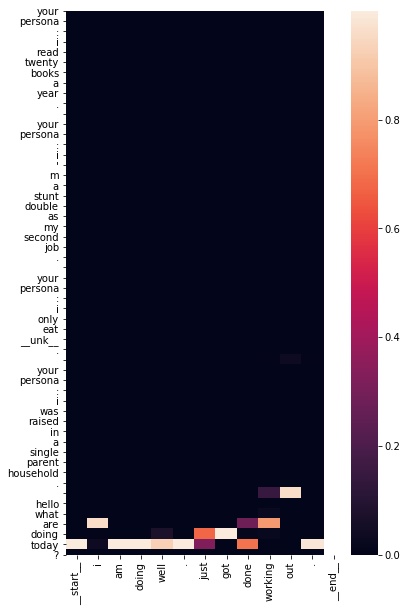

In [117]:
idx = 0
print('current idx {}'.format(idx))
x = valid_dataset[idx]
plot_heatmap(baseline, x, batch_size=1)

current idx 3447
inputs: your persona : i love dogs , especially labradors . 
 your persona : i am traveling to paris this year for my vacation . 
 your persona : i work in the pharmaceutical industry . 
 your persona : i was born in san francisco . 
 i am around pets all day . do you have any pets ? 
 yes i do i have 3 dogs . 
 that ' s cool i ' ve 3 dogs too and 2 crazy cats . 
 what kind of dogs do you have . 
 i am also a vet so i work around other pets every day . 
 oh that s great . i love animals . 
 i ' ve 3 dobermans at home and about 100 at work .
predicted: __start__ i ' m a vet tech . i ' m a vet . __end__
target: where are you from ? i live in california . __end__
134 ['your', 'persona', ':', 'i', 'love', 'dogs', ',', 'especially', 'labradors', '.', '\n', 'your', 'persona', ':', 'i', 'am', 'traveling', 'to', 'paris', 'this', 'year', 'for', 'my', 'vacation', '.', '\n', 'your', 'persona', ':', 'i', 'work', 'in', 'the', 'pharmaceutical', 'industry', '.', '\n', 'your', 'person

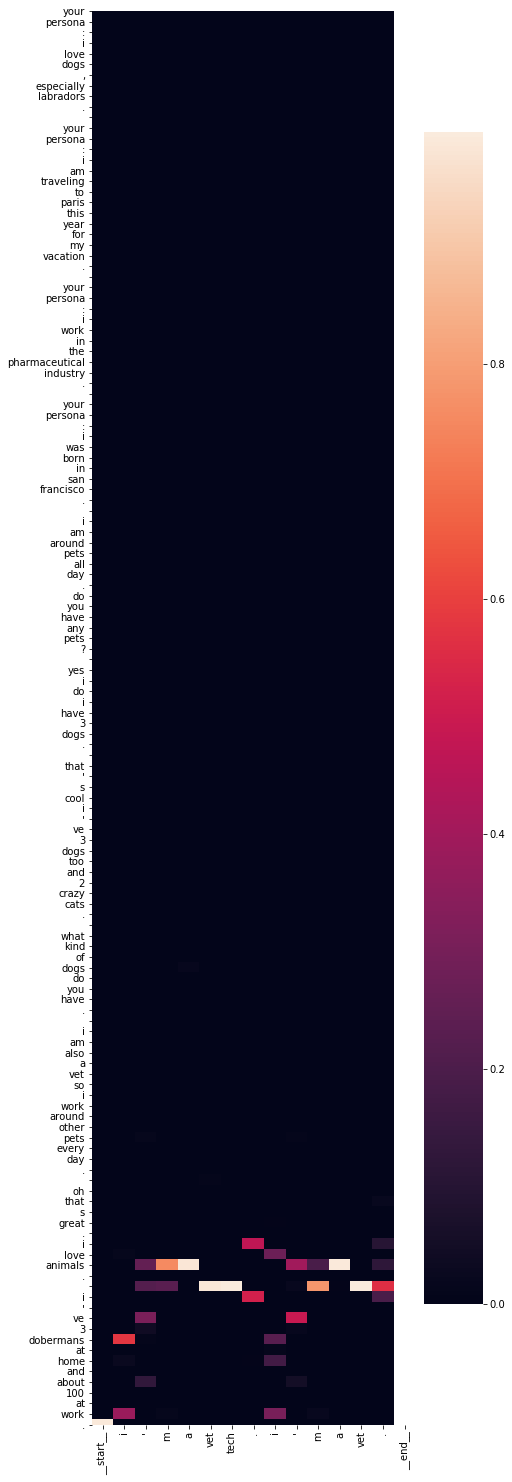

In [118]:
idx = random.randint(0,len(valid_dataset))
print('current idx {}'.format(idx))
x = train_dataset[idx]
plot_heatmap(baseline, x, batch_size=1)

current idx 3348
inputs: your persona : i have a cat . 
 your persona : subway is my favorite fast food restaurant . 
 your persona : i spend my weekends browsing antique stores . 
 your persona : i collect little figurines . 
 your persona : starbucks is my favorite hang out spot . 
 hello how are you today ? 
 good just got done searching an antique shop . you ? 
 not much looking at my college website i go there soon 
 which school are you going to ? 
 a u of m i ' m currently working over at the local walmart 
 seems like a good job . can sort of do your own thing . 
 true what do you have planned tonight ? 
 just staying in and writing . 
 i have to help dad in the shop later he ' s a mechanic 
 that is kind of you to do . like it ? 
 its alright mom is making veggie burgers tonight
predicted: __start__ i ' ve a cat named cow . __end__
target: are you a vegetarian ? i am . __end__
174 ['your', 'persona', ':', 'i', 'have', 'a', 'cat', '.', '\n', 'your', 'persona', ':', 'subway', 'i

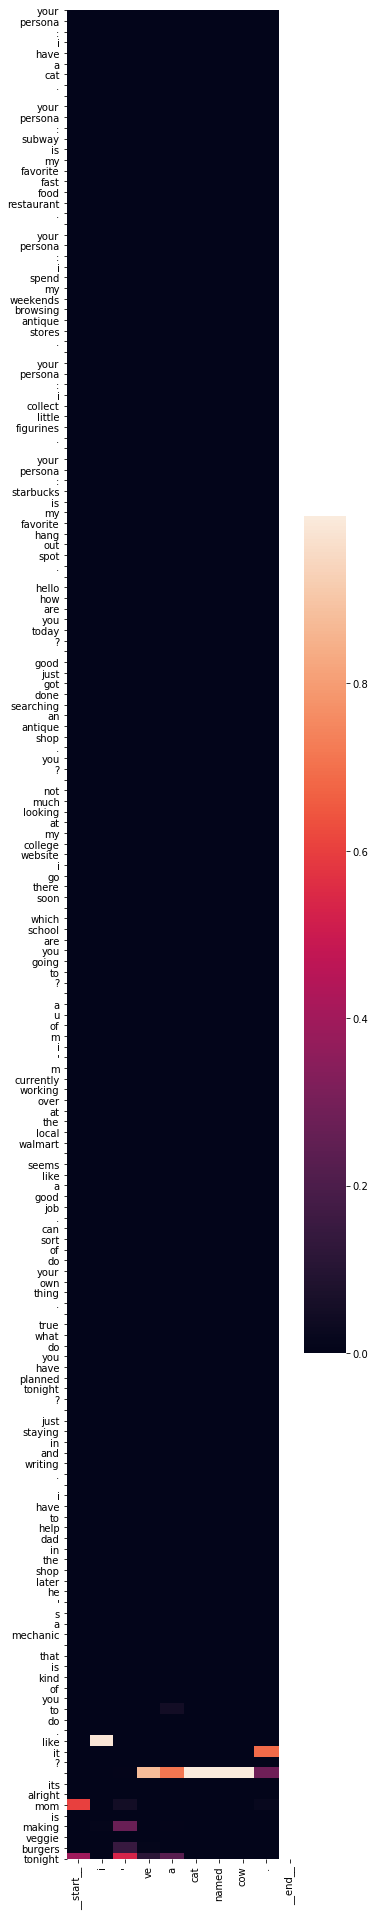

In [119]:
idx = random.randint(0,len(valid_dataset))
print('current idx {}'.format(idx))
x = train_dataset[idx]
plot_heatmap(baseline, x, batch_size=1)

current idx 5980
inputs: your persona : i don t like to eat meat . 
 your persona : my favorite fruit is apple . 
 your persona : i like fruit . 
 your persona : i like green apples . 
 hello how are you today ? 
 i ' m doing well but i ' m a little hungry . how are you ? 
 i am starving , we should hunt dinner 
 i do not like to eat meat . do you like to hunt ? 
 i like hunting with my 2 kids 
 that ' s great but i prefer eating apples . 
 i used to donate apples 
 did you donate any green apples which i like . 
 sure , do you have pets ? 
 i do not have any pets . do you like animals ? 
 yeah i like cats i ' ve 2
predicted: __start__ i love cats . i ' ve a dog . __end__
target: i ' d prefer one that likes fruit as i do ; perhaps an iguana . __end__
153 ['your', 'persona', ':', 'i', 'don', 't', 'like', 'to', 'eat', 'meat', '.', '\n', 'your', 'persona', ':', 'my', 'favorite', 'fruit', 'is', 'apple', '.', '\n', 'your', 'persona', ':', 'i', 'like', 'fruit', '.', '\n', 'your', 'persona', 

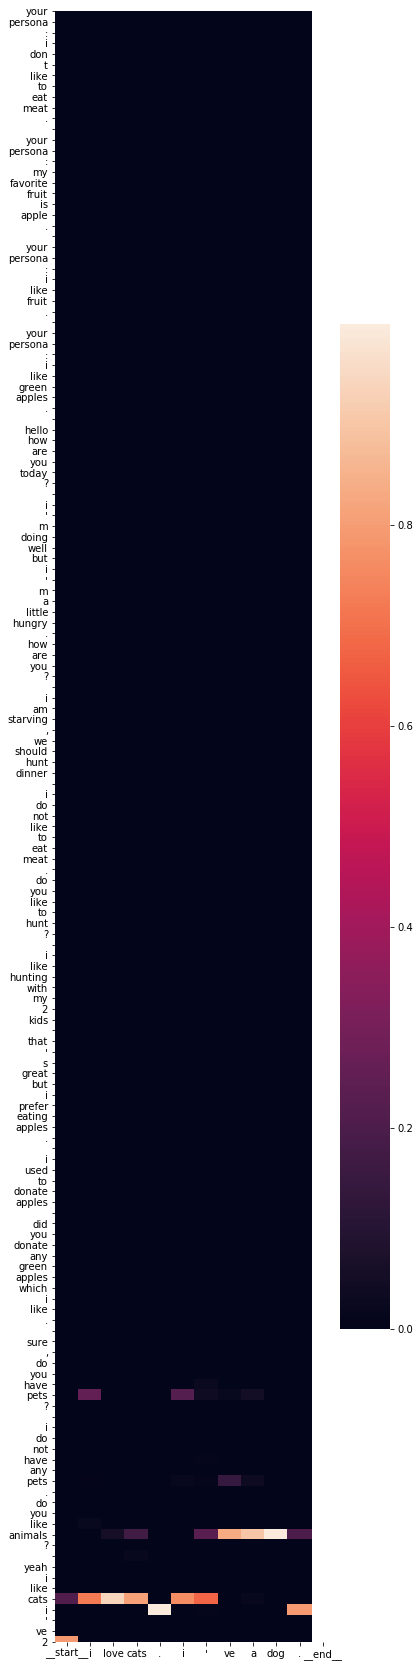

In [120]:
idx = random.randint(0,len(valid_dataset))
print('current idx {}'.format(idx))
x = train_dataset[idx]
plot_heatmap(baseline, x, batch_size=1)

current idx 5227
inputs: your persona : i want to climb mount everest . 
 your persona : i have shot a lion . 
 your persona : i cry when i watch gone with the wind . 
 your persona : i like to play with clay models . 
 your persona : i ' m not a good artist . 
 i ' m a hot mess . . . wanna hear how ? 
 yeah sure 
 i hear voices . 
 anything else ? 
 i like to argue . . . with myself . 
 so you must be good at debate 
 i mostly just argue about how hot the pool boy is . 
 that is usually hotly debated . i cry when i watch movies 
 let me guess . . . gone with the wind gets ya ?
predicted: __start__ i ' m a pro ball player __end__
target: aw , how did you know ? cries and cries and cries __end__
143 ['your', 'persona', ':', 'i', 'want', 'to', 'climb', 'mount', 'everest', '.', '\n', 'your', 'persona', ':', 'i', 'have', 'shot', 'a', 'lion', '.', '\n', 'your', 'persona', ':', 'i', 'cry', 'when', 'i', 'watch', 'gone', 'with', 'the', 'wind', '.', '\n', 'your', 'persona', ':', 'i', 'like', 't

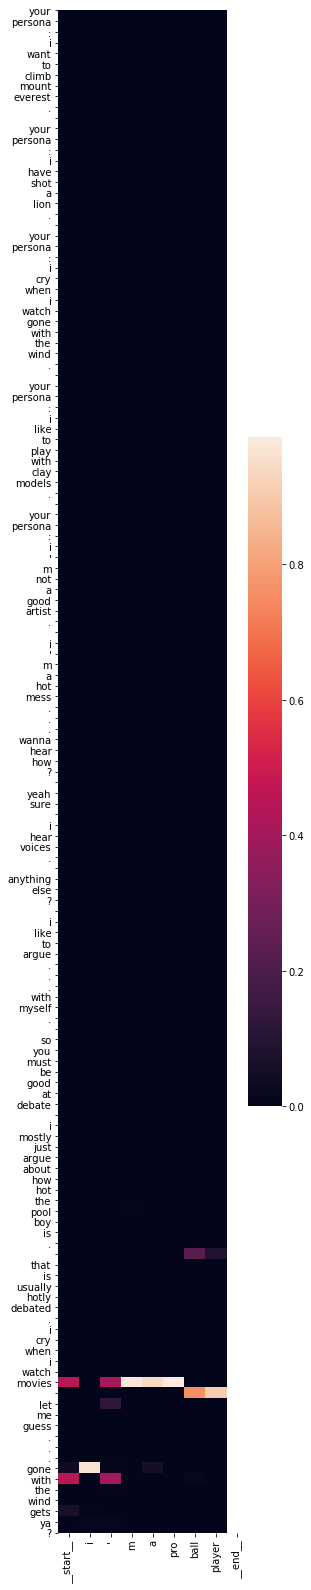

In [121]:
idx = random.randint(0,len(valid_dataset))
print('current idx {}'.format(idx))
x = train_dataset[idx]
plot_heatmap(baseline, x, batch_size=1)

## 1.2 Encoder Transformer

In [ ]:
### add transformer encoder as optional encoder in seq2seq model.

# code below can help you to start it, but feel free to start from scratch

class EncoderTransformer(nn.Module):
     def __init__(self):
        
        # you need to add more things here
        
        self.position_embed = nn.Embedding()
        encoder_layer = nn.TransformerEncoderLayer()
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=1)

     def forward(self, text_vec):
        # some helpful directions below, check the MLM lab for more details
        
        # embedded = pos_embedded + embedded  # apply pos embedding
        # attention_mask = ...
        # output = self.transformer(embedded, src_key_padding_mask=attention_mask)
        return None
        

In [ ]:
###################### my code below ######################

In [ ]:
### add transformer encoder as optional encoder in seq2seq model.

class EncoderTransformer(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers=2,
                  pad_idx=0, dropout=0, nhead=4, shared_lt=None):
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = nn.Dropout(p=dropout)
        self.pad_idx = pad_idx
        # position embedding
        self.token_embed = nn.Embedding(self.vocab_size, self.embed_size, self.pad_idx)
        self.position_embed = nn.Embedding(2000, self.embed_size)
        # transformer encoding
        encoder_layer = nn.TransformerEncoderLayer(d_model=self.embed_size, nhead=nhead, dim_feedforward=256, dropout=0.2)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, text_vec, text_lens, hidden=None, use_packed=False):
        # embedded = pos_embedded + embedded  # apply pos embedding
        pos = torch.arange(len(text_vec), device=text_vec.device).unsqueeze(1)
        embedded = self.token_embed(text_vec) + self.position_embed(pos)    
        embedded = self.dropout(embedded)
        attention_mask = text_vec.ne(self.pad_idx)
        output = self.transformer(embedded)

        return output, None, attention_mask

    
class seq2seq(nn.Module):
    """
    Generic seq2seq model with attention mechanism.
    """
    def __init__(self, opts):
        super().__init__()
        self.opts = opts

        self.decoder = DecoderRNN(
                                    vocab_size=self.opts['vocab_size'],
                                    embed_size=self.opts['embedding_size'],
                                    hidden_size=self.opts['hidden_size'],
                                    num_layers=self.opts['num_layers_dec'],
                                    dropout=self.opts['dropout'],
                                )
        
        ## use Transformer Encoder ##
        self.encoder = EncoderTransformer(
                                    vocab_size=self.opts['vocab_size'],
                                    embed_size=self.opts['embedding_size'],
                                    hidden_size=self.opts['hidden_size'],
                                    num_layers=self.opts['num_layers_dec'],
                                    dropout=self.opts['dropout'],
                                    shared_lt=self.decoder.embedding
        )

    def train(self):
        self.encoder.train()
        self.decoder.train()

    def eval(self):
        self.encoder.eval()
        self.decoder.eval()

In [126]:
num_gpus = torch.cuda.device_count()
if num_gpus > 0:
    current_device = 'cuda'
else:
    current_device = 'cpu'

load_pretrained = False
    
opts = {}
opts['vocab_size'] = len(chat_dict)
opts['hidden_size'] = 256
opts['embedding_size'] = 256
opts['num_layers_enc'] = 2
opts['num_layers_dec'] = 2
opts['dropout'] = 0.3
opts['shared_lt'] = True

model = seq2seq(opts)
model.to(current_device)

seq2seq(
  (decoder): DecoderRNN(
    (dropout): Dropout(p=0.3, inplace=False)
    (embedding): Embedding(18760, 256, padding_idx=0)
    (gru): GRU(256, 256, num_layers=2, batch_first=True, dropout=0.3)
    (attention): AttentionLayer(
      (linear_out): Linear(in_features=512, out_features=256, bias=False)
      (softmax): Softmax(dim=-1)
      (tanh): Tanh()
    )
    (out): Linear(in_features=256, out_features=18760, bias=True)
  )
  (encoder): EncoderTransformer(
    (dropout): Dropout(p=0.3, inplace=False)
    (token_embed): Embedding(18760, 256, padding_idx=0)
    (position_embed): Embedding(2000, 256)
    (transformer): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): Linear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.2, inplace=False)
          (linear2): 

In [ ]:
import numpy as np

def ppl(i):
    return 2**(i/np.log(2))

## You present here:

In [ ]:
# check pdf to see what you expected to present

In [12]:
criterion = nn.CrossEntropyLoss(ignore_index=0, reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, amsgrad=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10)

plot_cache = []
best_val_loss = 100

for epoch in range(30):
    
  model.train()
  sum_loss = 0
  sum_tokens = 0
    
  for i, batch in enumerate(train_loader):
    optimizer.zero_grad()
    text_vecs = batch['text_vecs'].to(current_device)
    target_vecs = batch['target_vecs'].to(current_device)
    
    #################################
    # substitute for transformer encoder 
    encoded = model.encoder(text_vecs, batch['text_lens'], use_packed=batch['use_packed'])
    #################################
  
    decoder_output, preds, attn_w_log = model.decoder.decode_forced(target_vecs, encoded, batch['text_lens'])
    
    scores = decoder_output.view(-1, decoder_output.size(-1))
    
    loss = criterion(scores, target_vecs.view(-1))
    sum_loss += loss.item()
    
    num_tokens = target_vecs.ne(0).long().sum().item()
    loss /= num_tokens
    
    sum_tokens += num_tokens
    
    loss.backward()
    optimizer.step()
    
    if i % 100 == 0:
      avg_train_loss = sum_loss/sum_tokens
      #print("iter {} train loss = {}".format(i, sum_loss/sum_tokens))
            
  val_loss = 0
  val_tokens = 0
  for i, batch in enumerate(valid_loader):
    model.eval()

    text_vecs = batch['text_vecs'].to(current_device)
    target_vecs = batch['target_vecs'].to(current_device)

    encoded = model.encoder(text_vecs, batch['text_lens'], use_packed=batch['use_packed'])

    decoder_output, preds, attn_w_log = model.decoder.decode_forced(target_vecs, encoded, batch['text_lens'])

    scores = decoder_output.view(-1, decoder_output.size(-1))

    loss = criterion(scores, target_vecs.view(-1))

    num_tokens = target_vecs.ne(0).long().sum().item()

    val_tokens += num_tokens
    val_loss += loss.item()
      
  avg_val_loss = val_loss/val_tokens
  scheduler.step(avg_val_loss)
  print("Epoch {} valid loss = {}, train loss = {}".format(epoch, avg_val_loss, avg_train_loss))
  print("Current training perplexity = {}, validation perplexity = {} \n".format( ppl(avg_train_loss), ppl(avg_val_loss) ))
  #print("Current validation perplexity = {}".format(ppl(avg_val_loss)))

  plot_cache.append( (avg_train_loss, avg_val_loss) )
  
  if avg_val_loss < best_val_loss:
    best_val_loss = avg_val_loss
    
    torch.save({
    'state_dict': model.state_dict(),
    'opts': opts,
    'plot_cache': plot_cache,
        }, f'./chat_model_best_{epoch}.pt')

Epoch 0 valid loss = 4.231568763377286, train loss = 4.964989791979181
Current training perplexity = 143.3070873841458, validation perplexity = 68.82511785249432 

Epoch 1 valid loss = 3.967215525113264, train loss = 4.021572676904088
Current training perplexity = 55.788774588710766, validation perplexity = 52.837201956146146 

Epoch 2 valid loss = 3.8827344611416126, train loss = 3.8201747994838025
Current training perplexity = 45.612180609678134, validation perplexity = 48.55681041155253 

Epoch 3 valid loss = 3.865258354835581, train loss = 3.7070690745165567
Current training perplexity = 40.734242366757954, validation perplexity = 47.71559839596226 

Epoch 4 valid loss = 3.788551027138324, train loss = 3.6274708922840313
Current training perplexity = 37.61755735293069, validation perplexity = 44.192320389247854 

Epoch 5 valid loss = 3.775169420283088, train loss = 3.566724180837294
Current training perplexity = 35.400437571398136, validation perplexity = 43.60489524365431 

Epoch 

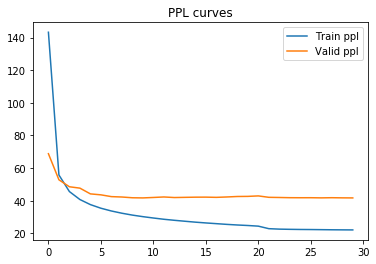

In [13]:
import matplotlib.pyplot as plt
import numpy

epochs = numpy.array(list(range(len(plot_cache))))
plt.plot(epochs, [2**(i[0]/numpy.log(2)) for i in plot_cache], label='Train ppl')
plt.plot(epochs, [2**(i[1]/numpy.log(2)) for i in plot_cache], label='Valid ppl')

plt.legend()
plt.title('PPL curves')
plt.show()

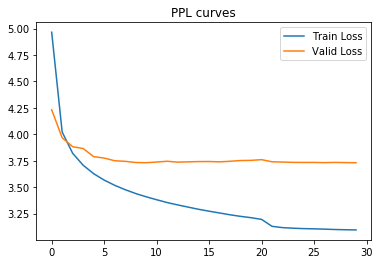

In [14]:
epochs = numpy.array(list(range(len(plot_cache))))
plt.plot(epochs, [i[0] for i in plot_cache], label='Train Loss')
plt.plot(epochs, [i[1] for i in plot_cache], label='Valid Loss')

plt.legend()
plt.title('PPL curves')
plt.show()

# Part 2 Decoding

# 2.1 Nucleus Sampling

In [ ]:
def nucleus_sampling(model, batch, top_p):
    model.eval()
        
    text_vecs = batch['text_vecs'].to(current_device)
    encoded = model.encoder(text_vecs, batch['text_lens'], use_packed=batch['use_packed'])
    
    encoder_output, encoder_hidden, attention_mask = encoded
        
    starts = torch.Tensor([1]).long().to(model.decoder.embedding.weight.device).expand(batch_size, 1).long()  # expand to batch size
    decoder_hidden = encoder_hidden
    xs = starts
    sampling = []
    log_p = 0
    
    for ts in range(100):
        decoder_output, decoder_hidden, attn_w_log = model.decoder(xs, decoder_hidden, encoded) 
        logits = torch.softmax(decoder_output,dim=-1)[0][-1]
        sorted_logits, sorted_indices = torch.sort(logits, descending=True)

        i = 1
        while torch.sum(sorted_logits[:i])<top_p:
            i+=1

        dist = sorted_logits[:i]
#         print(dist)
        norm = dist/torch.sum(dist)
        sample = torch.multinomial(norm, 1)
        xs = sorted_indices[sample].to(current_device).expand(1,1).long()
        sampling.append(int(xs))

        log_p+=np.log2(float(logits[int(xs)]))    
        if int(xs)==2:
            break  
        uniq_token = len(set(sampling))
    return sampling,log_p,uniq_token

In [130]:
# idx = random.randint(0,len(valid_dataset))
batch_size = 1
valid_sample = next(iter(DataLoader([valid_dataset[0]], shuffle=False, collate_fn=batchify, batch_size=batch_size)))
print('idx: {}\n'.format(0))
print('inputs: {}\n'.format( chat_dict.v2t(valid_sample['text_vecs'].tolist()[0])))
print('target: {}\n'.format( chat_dict.v2t(valid_sample['target_vecs'].tolist()[0])))

idx: 0

inputs: your persona : i read twenty books a year . 
 your persona : i ' m a stunt double as my second job . 
 your persona : i only eat __unk__ . 
 your persona : i was raised in a single parent household . 
 hello what are doing today ?

target: i am good , i just got off work and tired , i have two jobs . __end__



In [ ]:
avg1 = []
avg2 = []
avg3 = []
seq1 = []
seq2 = []
seq3 = []
uniq1 = []
uniq2 = []
uniq3 = []

for ts in range(100):
    s1,avg_log_p1,u1 = nucleus_sampling(baseline, valid_sample, 0.1)
    avg1.append(avg_log_p1.item())
    seq1.append(chat_dict.v2t(s1)) 
    uniq1.append(u1)
    s2,avg_log_p2,u2 = nucleus_sampling(baseline, valid_sample, 0.5)
    avg2.append(avg_log_p2.item())
    seq2.append(chat_dict.v2t(s2))
    uniq2.append(u2)

    s3,avg_log_p3,u3 = nucleus_sampling(baseline, valid_sample, 0.9)
    avg3.append(avg_log_p3.item())
    seq3.append(chat_dict.v2t(s3))
    uniq3.append(u3)


## You present here:

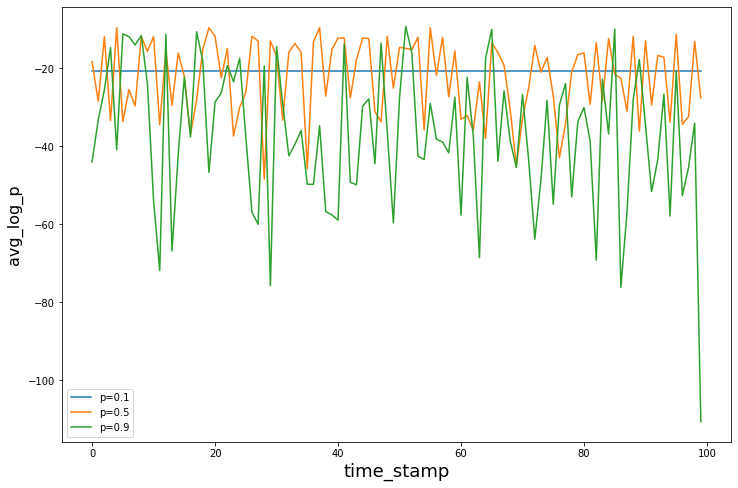

In [132]:
plt.figure(figsize = (12,8))
# plt.ylim((0,0.5))
plt.xlabel('time_stamp', fontsize=18)
plt.ylabel('avg_log_p', fontsize=16)

plt.plot([ts for ts in range(100)],avg1,label='p=0.1')
plt.plot([ts for ts in range(100)],avg2,label='p=0.5')
plt.plot([ts for ts in range(100)],avg3,label='p=0.9')
plt.legend()
plt.show()

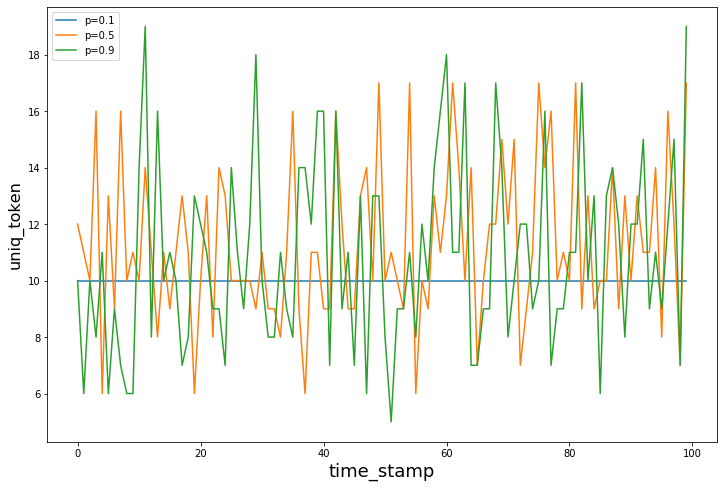

In [133]:
plt.figure(figsize = (12,8))
# plt.ylim((0,0.5))
plt.xlabel('time_stamp', fontsize=18)
plt.ylabel('uniq_token', fontsize=16)

plt.plot([ts for ts in range(100)],uniq1,label='p=0.1')
plt.plot([ts for ts in range(100)],uniq2,label='p=0.5')
plt.plot([ts for ts in range(100)],uniq3,label='p=0.9')
plt.legend()
plt.show()

In [ ]:
# check pdf to see what you expected to present

## 2.2 N-Gram blocking

In [ ]:
import math
from operator import attrgetter

class _HypothesisTail(object):
    """Hold some bookkeeping about a hypothesis."""

    # use slots because we don't want dynamic attributes here
    __slots__ = ['timestep', 'hypid', 'score', 'tokenid']

    def __init__(self, timestep, hypid, score, tokenid):
        self.timestep = timestep
        self.hypid = hypid
        self.score = score
        self.tokenid = tokenid

class Beam(object):
    """
    This class serves to keep info about partial hypothesis and perform the beam step
    """
    
    def __init__(
        self,
        beam_size,
        padding_token=0,
        bos_token=1,
        eos_token=2,
        min_length=3,
        min_n_best=3,
        device='cpu',
        # for iterbeam below
        similarity_metric='hamming',
        similarity_threshold=0,
    ):
        
        self.beam_size = beam_size
        self.min_length = min_length
        self.eos = eos_token
        self.bos = bos_token
        self.pad = padding_token
        self.device = device
        # recent score for each hypo in the beam
        self.scores = None
        # self.scores values per each time step
        self.all_scores = [torch.Tensor([0.0] * beam_size).to(self.device)]
        # backtracking id to hypothesis at previous time step
        self.bookkeep = []
        # output tokens at each time step
        self.outputs = [
            torch.Tensor(self.beam_size).long().fill_(self.bos).to(self.device)
        ]
        # keeps tuples (score, time_step, hyp_id)
        self.finished = []
        self.eos_top = False
        self.eos_top_ts = None
        self.n_best_counter = 0
        self.min_n_best = min_n_best
        self.partial_hyps = [[self.bos] for i in range(beam_size)]

        # iterbeam related below
        self.history_hyps = []
        self.similarity_metric = similarity_metric
        self.similarity_threshold = similarity_threshold
        self.banned_tokens = set()
    def get_output_from_current_step(self):
        """Get the output at the current step."""
        return self.outputs[-1]

    def get_backtrack_from_current_step(self):
        """Get the backtrack at the current step."""
        return self.bookkeep[-1]
    
    ##################### ITER-BEAM BLOCKING PART START #####################
    
    def hamming_distance(self, t1, t2):
        dist = 0
        for tok1, tok2 in zip(t1,t2):
            if tok1 != tok2:
                dist += 1
        return dist
    
    def edit_distance(self, t1, t2):
        import editdistance
        dist = editdistance.eval(t1, t2)
        return dist
                
    def similarity_check(self, active_hyp, previous_hyps, metric='hamming', threshold=0):
        return []
        banned_tokens = []
        active_len = len(active_hyp)
        for observed_hyp, _banned_tokens in previous_hyps.items():
            if len(observed_hyp) != active_len:
                continue
            if metric == 'hamming':
                dist = self.hamming_distance(observed_hyp, active_hyp)
            if metric == 'edit':
                dist = self.edit_distance(observed_hyp, active_hyp)
            if dist <= threshold:
                banned_tokens.extend(_banned_tokens)
                    
        return list(set(banned_tokens))

    def n_gram_check(self, active_hyp, n = 0):
        
        banned_tokens = []
        active_len = len(active_hyp)
        if active_len < n:
            return banned_tokens
        if n == 0:
            return []
        elif n == 1:
            banned_tokens = [int(i) for i in active_hyp]
        else:
            appeared = [list(active_hyp[i:i+n]) for i in range(active_len)][:-n+1]
            next_prefix = list(active_hyp[-n + 1:])
            banned_tokens = [i[-1] for i in appeared if i[:-1] == next_prefix]
            # print('active_hyp: {}'.format(active_hyp))
            # print('next_prefix: {}'.format(next_prefix))
            # print('appeared: {}'.format(appeared))
            # print('banned_tokens: {}'.format(banned_tokens))
            
        return list(set(banned_tokens))      
    
    ##################### ITER-BEAM BLOCKING PART END ########################
    
    def select_paths(self, logprobs, prior_scores, previous_hyps, n = 0):
        """Select the next vocabulary item in these beams."""
        # beam search actually looks over all hypotheses together so we flatten


        beam_scores = logprobs + prior_scores.unsqueeze(1).expand_as(logprobs)

        # iterbeam blocking part
        current_length = len(self.all_scores)
        if len(previous_hyps) >= 0 and current_length > 0:
            for hyp_id in range(beam_scores.size(0)):
                active_hyp = tuple(self.partial_hyps[hyp_id])
                banned_tokens = self.similarity_check(active_hyp, previous_hyps, metric=self.similarity_metric, threshold=self.similarity_threshold)
                banned_tokens = self.n_gram_check(active_hyp, n = n)
                if len(banned_tokens) > 0:
                    beam_scores[:, banned_tokens] = -10e5
            
        flat_beam_scores = beam_scores.view(-1)
        # print(flat_beam_scores.shape)
        best_scores, best_idxs = torch.topk(flat_beam_scores, self.beam_size, dim=-1)
        # print('best_scores: {}'.format(best_scores))
        # print('best_idxs: {}'.format(best_idxs))
        voc_size = logprobs.size(-1)

        # get the backtracking hypothesis id as a multiple of full voc_sizes
        hyp_ids = best_idxs / voc_size
        # get the actual word id from residual of the same division
        tok_ids = best_idxs % voc_size

        return (hyp_ids, tok_ids, best_scores)
    
    def advance(self, logprobs, previous_hyps, n = 0):
        """Advance the beam one step."""
        current_length = len(self.all_scores) - 1
        if current_length < self.min_length:
            # penalize all eos probs to make it decode longer
            for hyp_id in range(logprobs.size(0)):
                logprobs[hyp_id][self.eos] = -10e5


        if self.scores is None:
            logprobs = logprobs[0:1]  # we use only the first hyp now, since they are all same
            self.scores = torch.zeros(1).type_as(logprobs).to(logprobs.device)
            
        hyp_ids, tok_ids, self.scores = self.select_paths(logprobs, self.scores, previous_hyps, n = n)
        
        # clone scores here to avoid referencing penalized EOS in the future!
        self.all_scores.append(self.scores.clone())

        self.outputs.append(tok_ids)
        self.bookkeep.append(hyp_ids)
        self.partial_hyps = [
            self.partial_hyps[hyp_ids[i]] + [tok_ids[i].item()]
            for i in range(self.beam_size)
        ]
        self.history_hyps.extend(self.partial_hyps)
        #  check new hypos for eos label, if we have some, add to finished
        for hypid in range(self.beam_size):
            if self.outputs[-1][hypid] == self.eos:
                self.scores[hypid] = -10e5
                #  this is finished hypo, adding to finished
                eostail = _HypothesisTail(
                    timestep=len(self.outputs) - 1,
                    hypid=hypid,
                    score=self.all_scores[-1][hypid],
                    tokenid=self.eos,
                )
                self.finished.append(eostail)
                self.n_best_counter += 1

        if self.outputs[-1][0] == self.eos:
            self.eos_top = True
            if self.eos_top_ts is None:
                self.eos_top_ts = len(self.outputs) - 1
    
    def is_done(self):
        """Return whether beam search is complete."""
        return self.eos_top and self.n_best_counter >= self.min_n_best

    def get_top_hyp(self):
        """
        Get single best hypothesis.
        :return: hypothesis sequence and the final score
        """
        return self._get_rescored_finished(n_best=1)[0]

    def _get_hyp_from_finished(self, hypothesis_tail):
        """
        Extract hypothesis ending with EOS at timestep with hyp_id.
        :param timestep:
            timestep with range up to len(self.outputs) - 1
        :param hyp_id:
            id with range up to beam_size - 1
        :return:
            hypothesis sequence
        """
        hyp_idx = []
        endback = hypothesis_tail.hypid
        for i in range(hypothesis_tail.timestep, -1, -1):
            hyp_idx.append(
                _HypothesisTail(
                    timestep=i,
                    hypid=endback,
                    score=self.all_scores[i][endback],
                    tokenid=self.outputs[i][endback],
                )
            )
            endback = self.bookkeep[i - 1][endback]

        return hyp_idx

    def _get_pretty_hypothesis(self, list_of_hypotails):
        """Return hypothesis as a tensor of token ids."""
        return torch.stack([ht.tokenid for ht in reversed(list_of_hypotails)])

    def _get_rescored_finished(self, n_best=None, add_length_penalty=False):
        """
        Return finished hypotheses according to adjusted scores.
        Score adjustment is done according to the Google NMT paper, which
        penalizes long utterances.
        :param n_best:
            number of finalized hypotheses to return
        :return:
            list of (tokens, score) pairs, in sorted order, where:
              - tokens is a tensor of token ids
              - score is the adjusted log probability of the entire utterance
        """
        # if we never actually finished, force one
        if not self.finished:
            self.finished.append(
                _HypothesisTail(
                    timestep=len(self.outputs) - 1,
                    hypid=0,
                    score=self.all_scores[-1][0],
                    tokenid=self.eos,
                )
            )

        rescored_finished = []
        for finished_item in self.finished:
            if add_length_penalty:
                current_length = finished_item.timestep + 1
                # these weights are from Google NMT paper
                length_penalty = math.pow((1 + current_length) / 6, 0.65)
            else:
                length_penalty = 1
            rescored_finished.append(
                _HypothesisTail(
                    timestep=finished_item.timestep,
                    hypid=finished_item.hypid,
                    score=finished_item.score / length_penalty,
                    tokenid=finished_item.tokenid,
                )
            )

        # Note: beam size is almost always pretty small, so sorting is cheap enough
        srted = sorted(rescored_finished, key=attrgetter('score'), reverse=True)

        if n_best is not None:
            srted = srted[:n_best]

        return [
            (self._get_pretty_hypothesis(self._get_hyp_from_finished(hyp)), hyp.score)
            for hyp in srted
        ]

In [ ]:
def reorder_encoder_states(encoder_states, indices):
        """Reorder encoder states according to a new set of indices."""
        enc_out, hidden, attention_mask = encoder_states

        # LSTM or GRU/RNN hidden state?
        if isinstance(hidden, torch.Tensor):
            hid, cell = hidden, None
        else:
            hid, cell = hidden

        if not torch.is_tensor(indices):
            # cast indices to a tensor if needed
            indices = torch.LongTensor(indices).to(hid.device)

        hid = hid.index_select(1, indices)
        if cell is None:
            hidden = hid
        else:
            cell = cell.index_select(1, indices)
            hidden = (hid, cell)

        enc_out = enc_out.index_select(0, indices)
        attention_mask = attention_mask.index_select(0, indices)

        return enc_out, hidden, attention_mask
    
    
def reorder_decoder_incremental_state(incremental_state, inds):
    if torch.is_tensor(incremental_state):
        # gru or lstm
        return torch.index_select(incremental_state, 1, inds).contiguous()
    elif isinstance(incremental_state, tuple):
        return tuple(
            self.reorder_decoder_incremental_state(x, inds)
            for x in incremental_state)

def get_nbest_list_from_beam(beam, dictionary, n_best=None, add_length_penalty=False):
    if n_best is None:
        n_best = beam.min_n_best
    nbest_list = beam._get_rescored_finished(n_best=n_best, add_length_penalty=add_length_penalty)
    
    nbest_list_text = [(dictionary.v2t(i[0].cpu().tolist()), i[1].item()) for i in nbest_list]
    
    return nbest_list_text

In [ ]:
def generate_with_beam(beam_size, min_n_best, model, batch, batch_size, previous_hyps=None, similarity_metric='hamming', similarity_threshold=0, verbose=False, n = 0):
    """
    This function takes a model, batch, beam settings and performs decoding with a beam
    """
    beams = [Beam(beam_size, min_n_best=min_n_best, eos_token=chat_dict.word2ind['__end__'], \
                  padding_token=chat_dict.word2ind['__null__'], bos_token=chat_dict.word2ind['__start__'], \
                  device=current_device, similarity_metric=similarity_metric, similarity_threshold=similarity_threshold) for _ in range(batch_size)]
    repeated_inds = torch.arange(batch_size).to(current_device).unsqueeze(1).repeat(1, beam_size).view(-1)
    
    text_vecs = batch['text_vecs'].to(current_device)

    encoder_states = model.encoder(text_vecs, batch['text_lens'], use_packed=batch['use_packed'])
    
    model.eval()
    
    encoder_states = reorder_encoder_states(encoder_states, repeated_inds)  # no actual reordering here, but repeating beam size times each sample in the minibatch
    encoder_output, encoder_hidden, attention_mask = encoder_states
    
    incr_state = encoder_hidden  # we init decoder hidden with last encoder_hidden
    
    # 1 is a start token id
    starts = torch.Tensor([1]).long().to(model.decoder.embedding.weight.device).expand(batch_size*beam_size, 1).long()  # expand to batch_size * beam_size
    decoder_input = starts
    
    with torch.no_grad():
        for ts in range(100):
            if all((b.is_done() for b in beams)):
                break
            score, incr_state, attn_w_log = model.decoder(decoder_input, incr_state, encoder_states)
            score = score[:, -1:, :]  # take last time step and eliminate the dimension
            score = score.view(batch_size, beam_size, -1)
            score = torch.log_softmax(score, dim=-1)

            for i, b in enumerate(beams):
                if not b.is_done():
                    # make mock previous_hyps if not used #
                    if previous_hyps is None:
                        previous_hyps = [{} for i in range(batch_size)]

                    b.advance(score[i], previous_hyps[i], n = n)


            incr_state_inds = torch.cat([beam_size * i + b.get_backtrack_from_current_step() for i, b in enumerate(beams)])
            incr_state = reorder_decoder_incremental_state(incr_state, incr_state_inds)
            selection = torch.cat([b.get_output_from_current_step() for b in beams]).unsqueeze(-1)
            decoder_input = selection

    beam_preds_scores = [list(b.get_top_hyp()) for b in beams]

    if verbose:
        for bi in range(batch_size):
            # print(f'batch {bi}')
            for i, j in enumerate(get_nbest_list_from_beam(beams[bi], chat_dict, n_best=min_n_best)):
                print('Prediction {}: {}'.format(i,j[0][9:-7]))
    
    return beam_preds_scores, beams

## You present here:

In [ ]:
# check pdf to see what you expected to present

### No Blocking

In [193]:
batch_size = 1
beam_size = 20
beam_n_best = 10
n_gram = 0

idx = random.randint(0,len(valid_dataset))
valid_sample = next(iter(DataLoader([valid_dataset[7229]], shuffle=False, collate_fn=batchify, batch_size=batch_size)))
print('idx: {}\n'.format(7229))
print('inputs: {}\n'.format( chat_dict.v2t(valid_sample['text_vecs'].tolist()[0])))
print('target: {}\n'.format( chat_dict.v2t(valid_sample['target_vecs'].tolist()[0])))

print('Prediction for {}-Gram Blocking:'.format(n_gram))
beam_preds_scores, beams = generate_with_beam(beam_size, beam_n_best, baseline, valid_sample, batch_size=batch_size, verbose=True, n = n_gram)

idx: 7229

inputs: your persona : i spend my time bird watching with my cats . 
 your persona : i ' m an animal activist . 
 your persona : the holidays make me depressed . 
 your persona : my age is too old to say . 
 hey there coach danny here ! how are you ? 
 the same . me and the cats are watching the birds . 
 cool ! ! coffee and bird watching sounds fun 
 no coffee here . doctor says no . trials of being old i guess 
 wine ! ? wine in the evening is a must ! especially after little league

target: oh young people . the holidays are coming . that makes me sad . __end__

Prediction for 0-Gram Blocking:
Prediction 0:  i ' m not sure . i ' m afraid of heights 
Prediction 1:  i ' m not sure . i ' m afraid of heights . 
Prediction 2:  i ' m not sure . i ' m more of a movie person . 
Prediction 3:  i ' m not sure . i ' m not much of a reader 
Prediction 4:  i ' m not sure . i ' m more of a movie person 
Prediction 5:  i ' m not sure . i ' d love to be a vet 
Prediction 6:  i ' m not su

### 3-Gram Blocking

In [194]:
n_gram = 3

idx = random.randint(0,len(valid_dataset))
valid_sample = next(iter(DataLoader([valid_dataset[7229]], shuffle=False, collate_fn=batchify, batch_size=batch_size)))
print('idx: {}\n'.format(7229))
print('target: {}\n'.format( chat_dict.v2t(valid_sample['target_vecs'].tolist()[0])))

print('Prediction for {}-Gram Blocking:'.format(n_gram))
beam_preds_scores, beams = generate_with_beam(beam_size, beam_n_best, baseline, valid_sample, batch_size=batch_size, verbose=True, n = n_gram)

idx: 7229

target: oh young people . the holidays are coming . that makes me sad . __end__

Prediction for 3-Gram Blocking:
Prediction 0:  i ' m not sure . i ' ve a cat named radar 
Prediction 1:  i ' m not sure . i have a cat named cow . 
Prediction 2:  i ' m not sure . i ' ve a cat named cow 
Prediction 3:  i ' m not sure . i do not have a job . 
Prediction 4:  i ' m not sure . i do not have time for that 
Prediction 5:  i ' m not sure . i spend my time at the park . 
Prediction 6:  i ' m not sure . i ' ve a cat named radar . 
Prediction 7:  i ' m not sure . i spend my time at the gym . 
Prediction 8:  i ' m not sure . i spend my time on the internet . 
Prediction 9:  i ' m not sure . i do not have time for that . 


### 2-Gram Blocking

In [195]:
n_gram = 2

idx = random.randint(0,len(valid_dataset))
valid_sample = next(iter(DataLoader([valid_dataset[7229]], shuffle=False, collate_fn=batchify, batch_size=batch_size)))
print('idx: {}\n'.format(7229))
print('target: {}\n'.format( chat_dict.v2t(valid_sample['target_vecs'].tolist()[0])))

print('Prediction for {}-Gram Blocking:'.format(n_gram))
beam_preds_scores, beams = generate_with_beam(beam_size, beam_n_best, baseline, valid_sample, batch_size=batch_size, verbose=True, n = n_gram)

idx: 7229

target: oh young people . the holidays are coming . that makes me sad . __end__

Prediction for 2-Gram Blocking:
Prediction 0:  i ' m not sure . what do you do for a living ? 
Prediction 1:  i ' m not sure . what do you do ? 
Prediction 2:  i ' m not sure . what do you do for work ? 
Prediction 3:  i ' m not sure . what do you do for fun ? 
Prediction 4:  i ' m not sure . what do you like to do ? 
Prediction 5:  i ' m not sure . what do you like to do for fun ? 
Prediction 6:  i ' m not sure . what do you do in your spare time ? 
Prediction 7:  i ' m not sure . what do you do in your free time ? 
Prediction 8:  i ' m not sure . what do you like to eat ? 
Prediction 9:  i ' m not sure . what do you do for a living 


### 1-Gram Blocking

In [196]:
n_gram = 1

idx = random.randint(0,len(valid_dataset))
valid_sample = next(iter(DataLoader([valid_dataset[7229]], shuffle=False, collate_fn=batchify, batch_size=batch_size)))
print('idx: {}\n'.format(7229))
print('target: {}\n'.format( chat_dict.v2t(valid_sample['target_vecs'].tolist()[0])))

print('Prediction for {}-Gram Blocking:'.format(n_gram))
beam_preds_scores, beams = generate_with_beam(beam_size, beam_n_best, baseline, valid_sample, batch_size=batch_size, verbose=True, n = n_gram)

idx: 7229

target: oh young people . the holidays are coming . that makes me sad . __end__

Prediction for 1-Gram Blocking:
Prediction 0:  i ' m not a fan of music 
Prediction 1:  i ' m not a fan of heights 
Prediction 2:  i ' m not a fan of cats 
Prediction 3:  i ' m an editor at the local grocery store 
Prediction 4:  i ' m about to start my own restaurant tomorrow 
Prediction 5:  i ' m going to be the next one day 
Prediction 6:  i ' m an editor at the moment . you have pets ? 
Prediction 7:  i ' m an editor at the moment . you have any ? 
Prediction 8:  i ' m not a fan of music . what are your hobbies 
Prediction 9:  i ' m an editor at the moment . what are your hobbies 


# Part 3 Interactive chat

In [ ]:
# implement logic for interactive chat here
# the easiest is to just use python input functionality

In [ ]:
class ChatBot_DP(object):
    def __init__(self, dictionary, model, beam_size=20, maxNum=3):
        '''
        Initialize class variables.
        '''
        self.persona = None
        self.model = model
        self.chatHist = []
        self.dictionary = dictionary
        self.maxNum = maxNum
        self.beam_size = beam_size
        self.log = []
        
    def load_persona(self, idx=0):
        '''
        Load persona from dataset.
        '''
        # load a persona from validation set
        batch_size = 1
        chat_loader = DataLoader(valid_dataset, shuffle=False, collate_fn=batchify, batch_size=batch_size)
        curr_sample = next(iter(chat_loader))
        
        # only keep the persona 
        bot_attr = self.dictionary.v2t(curr_sample['text_vecs'][0].tolist())
        bot_attr = '\n'.join(bot_attr.split('\n')[:-1])
        self.persona = bot_attr
        
    def print_persona(self):
        '''
        This function prints out chatbot's persona.
        '''
        print('Chat Bot DP persona: \n{}'.format(self.persona))
        
    def get_input(self):
        '''
        This function takes user input and append to chat history.
        '''
        self.chatHist.append(input('Type a Message: '))
        
    def get_response(self):
        '''
        This function get response from chat bot by feeding all previous chatting history.
        '''
        beam_n_best = self.beam_size // 2
        
        # take all previous chatting history as input
        concat_input = ' \n'.join([self.persona] + self.chatHist)
        # print(concat_input)
        _inp_toked = RETOK.findall(concat_input)
        _inp_toked_id = self.dictionary.t2v(_inp_toked)
        
        sample = {'text_vecs': torch.tensor([_inp_toked_id]), 
                 'text_lens': [len(_inp_toked_id)],
                 'use_packed': True}
        self.log.append(sample)
        beam_preds_scores, beams = generate_with_beam(self.beam_size, beam_n_best, self.model, sample, batch_size=1, verbose=False, n=1)
        
        # out_id = beams[0].get_top_hyp()[random.randint(0,beam_n_best - 1)]
        out_id = beams[0]._get_rescored_finished(n_best=3)[random.randint(0, 2)][0]
        output = self.dictionary.v2t(out_id.tolist()[1:-1])
        self.chatHist.append(output)
        print('Chat Bot DP: {}'.format(output))
        
    def run(self):
        '''
        Main function for starting the chatbot.
        '''
        self.load_persona()
        self.print_persona()
        print('----- Let\'s Chat! -----')
        itr = 0
        while itr < self.maxNum:
            self.get_input()
            self.get_response()
            itr += 1
        print('It was Nice Chatting with You! [Max number of iteration reached, stop chatting.]')

## You present here:

In [ ]:
# check pdf to see what you expected to present

In [186]:
DP = ChatBot_DP(chat_dict, baseline, maxNum=5)
DP.run()

Chat Bot DP persona: 
your persona : i read twenty books a year . 
 your persona : i ' m a stunt double as my second job . 
 your persona : i only eat __unk__ . 
 your persona : i was raised in a single parent household . 
----- Let's Chat! -----
Type a Message: hello
Chat Bot DP: hey hows it going
Type a Message: not bad, you?
Chat Bot DP: good thanks for asking
Type a Message: How old are you?
Chat Bot DP: i ' m good what are your hobbies
Type a Message: I love to sing
Chat Bot DP: what is your favorite food
Type a Message: Pizza. What is your favorite food?
Chat Bot DP: chocolate chip cookies are my favorite
It was Nice Chatting with You! [Max number of iteration reached, stop chatting.]


In [187]:
DP.chatHist

['hello',
 'hey hows it going',
 'not bad, you?',
 'good thanks for asking',
 'How old are you?',
 "i ' m good what are your hobbies",
 'I love to sing',
 'what is your favorite food',
 'Pizza. What is your favorite food?',
 'chocolate chip cookies are my favorite']